In [1]:
def are_intersecting(boxes_people, bbox_shelves):
    matr_inters=np.zeros([len(boxes_people), len(bbox_shelves)])
    for i in range(len(boxes_people)):
        for j in range(len(bbox_shelves)):
            dx = min((boxes_people[i][0]+boxes_people[i][2]), bbox_shelves[j,:,0].max()) - \
                max(boxes_people[i][0], bbox_shelves[j,:,0].min())
            dy = min((boxes_people[i][1]+boxes_people[i][3]), bbox_shelves[j,:,1].max()) - \
                max(boxes_people[i][1], bbox_shelves[j,:,1].min())
            if (dx>0) and (dy>0):
                matr_inters[i,j]+=1   
    return matr_inters

In [9]:
import numpy as np
intersection_flag=0
polig_shelves=np.load('/home/zamarseny/Data_Science/input_data/taking_goods/cam33.npy')
polig_shelves[:,:,0]=(polig_shelves[:,:,0]*480/1920).astype(int)
polig_shelves[:,:,1]=(polig_shelves[:,:,1]*240/1080).astype(int)

In [10]:
polig_shelves

array([[[ 39,  52,  10,   8],
        [130,  33,  10,  10],
        [152, 116,   8,  10],
        [ 71, 122,   8,  10]],

       [[ 73, 129,  12,   8],
        [153, 123,  10,   8],
        [170, 172,  10,   6],
        [100, 174,  12,   6]],

       [[137,  32,   8,  12],
        [260,  23,  10,   8],
        [255, 168,  14,   8],
        [176, 172,  10,   6]],

       [[266,  23,  10,  12],
        [375,  30,  10,   8],
        [335, 161,  10,   8],
        [261, 168,  10,   4]]])

In [13]:

bbox4=np.array([[[154,  51,   6,   4],
       [293,  33,   4,   4],
       [288, 120,   8,   4],
       [184, 146,   4,   6]],
                
       [[312,  30,   8,   8],
       [392,  30,   6,   6],
       [374,  97,   6,   6],
       [302, 116,   6,  10]],
                
       [[405,  28,  10,   8],
       [441,  29,   6,   4],
       [430,  87,   4,   6],
       [387,  95,   6,   8]]]).astype(int)

In [5]:
import numpy as np
bbox4=np.array([[[ 39,  52,  10,   8],
        [130,  33,  10,  10],
        [152, 116,   8,  10],
        [ 71, 122,   8,  10]],

       [[ 73, 129,  12,   8],
        [153, 123,  10,   8],
        [170, 172,  10,   6],
        [100, 174,  12,   6]],

       [[137,  32,   8,  12],
        [260,  23,  10,   8],
        [255, 168,  14,   8],
        [176, 172,  10,   6]],

       [[266,  23,  10,  12],
        [375,  30,  10,   8],
        [335, 161,  10,   8],
        [261, 168,  10,   4]]]).astype(int)

In [11]:
# import the necessary packages

import argparse
import imutils
import psutil
from datetime import datetime
import time
import cv2
import os
 
# construct the argument parse and parse the arguments
'''ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True,
    help="path to input video")
ap.add_argument("-o", "--output", required=True,
    help="path to output video")
ap.add_argument("-y", "--yolo", required=True,
    help="base path to YOLO directory")'''
confidence_cutoff = 0.5 
'''ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")'''
thrsh=0.3 
'''ap.add_argument("-t", "--threshold", type=float, default=0.3,
    help="threshold when applyong non-maxima suppression")
args = vars(ap.parse_args())'''

# load the COCO class labels our YOLO model was trained on
labelsPath ='/home/zamarseny/darknet/data/coco.names'#labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")


# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

frm_nmb=0
start_time=datetime.now()

# derive the paths to the YOLO weights and model configuration
weightsPath ='/home/zamarseny/darknet/yolov3.weights'#weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath ='/home/zamarseny/darknet/cfg/yolov3.cfg'#configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/taking_goods/cam33.mp4')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/taking_goods/1.mp4')
writer = None
(W, H) = (None, None)
 
# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
 
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()
 
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
 
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
 
    # initialize our lists of detected bounding boxes, confidences,
    # and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    
    trigger=0
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability)
            # of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
 
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > confidence_cutoff and classID==0:#if confidence > args["confidence"]:
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
 
                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
 
                # update our list of bounding box coordinates,
                # confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_cutoff,#args["confidence"],
        thrsh)#args["threshold"])
 
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
 
            # draw a bounding box rectangle and label on the frame
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            #text = "{}: {:.2f}".format(LABELS[classIDs[i]],
            #    confidences[i])
            text = "{:.2f}".format(confidences[i])
            cv2.putText(frame, text, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            if intersection_flag==0:#== None:
                #matr_inters=np.zeros([len(boxes), len(polig_shelves)])
                inters_M_1=are_intersecting(boxes, polig_shelves)
                intersection_flag=1
            else:    
                inters_M_1=inters_M
            inters_M=are_intersecting(boxes, polig_shelves)
    
    
    for j in range(len(polig_shelves)):
        if len(idxs) == 0 or inters_M[0][j]==0:
            colour=(50,250,50)
        else:
            colour=(50,250,250)
        cv2.polylines(frame,[polig_shelves[j,:,0:2]],True,colour, 2)
    ''''''
    cur_time=datetime.now()#.strftime('%Y-%m-%d %H:%M:%S')
    d=cur_time-start_time
    cv2.putText(frame, 'frm_nmb: '+str(frm_nmb)+\
                    ' FPS: ' +str("{0:0.1f}".format(frm_nmb/(d.seconds+0.1))) \
                    +", CPU %: " + str((psutil.cpu_percent())) \
                    +", memory %: " + str(dict(psutil.virtual_memory()._asdict())['percent'])
                    #, (50,425, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50,50,100), 2);
                    , (int(frame.shape[1]*0.05),int(frame.shape[0]*0.95)), \
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,50,50), 2);   
        
    #cv2.imshow("Frame", frame) #NEW       
    cv2.imshow("Frame", cv2.resize(frame, (800,600)))
    
    frm_nmb+=1
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        #fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 20,
            (frame.shape[1], frame.shape[0]), True)
 
        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time to finish: {:.4f}".format(
                elap * total))
 
    # write the output frame to disk
    writer.write(frame)
    
    key = cv2.waitKey(1) & 0xFF
 
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()
cv2.destroyAllWindows()

[INFO] loading YOLO from disk...
[INFO] 1933 total frames in video
[INFO] single frame took 0.3536 seconds
[INFO] estimated total time to finish: 683.5075
[INFO] cleaning up...


In [6]:
print(len(classIDs))

27


In [12]:
inters_M(boxes, bbox4)#[0][j]

TypeError: 'numpy.ndarray' object is not callable

In [8]:
boxes

[[449, 70, 30, 54]]

In [20]:
frame=cv2.imread('/home/zamarseny/Data_Science/input_data/taking_goods/2019-06-30-12h16m38s-profile3.png')

In [14]:
box_people=np.array([[294, 76, 90, 150]]).astype(int)

In [15]:
inters_M=are_intersecting(box_people, bbox4)#[0][1]

array([[0., 1., 0.]])

In [36]:
plt.rcParams["figure.figsize"] = (20,10)

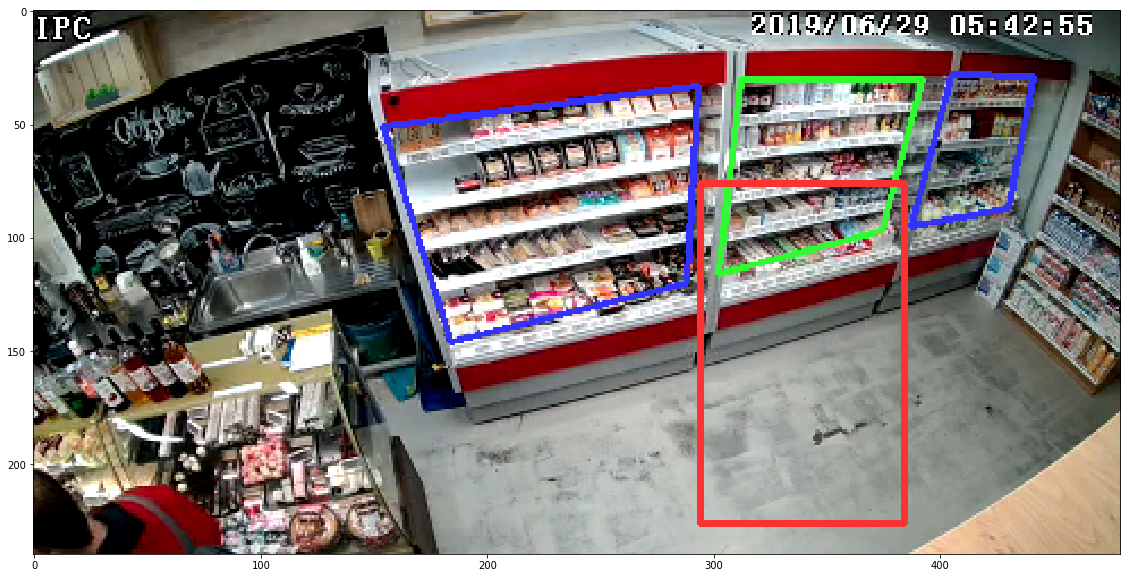

In [38]:
from matplotlib import pyplot as plt
for j in range(len(bbox4)):
        if are_intersecting(box_people, bbox4)[0][j]>0:
            colour=(50,250,50)
        else:
            colour=(250,50,50)
        cv2.polylines(frame,[bbox4[j,:,0:2]],True,colour, 2)

x,y,w,h=box_people[0]
cv2.rectangle(frame, (x, y), (x + w, y + h), (50,50,250), 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [79]:
m, n, o = frame.shape
#nx, ny = (round(m / 10), round(n / 8))
nx, ny=(9, 9)
x = np.linspace(0, m, nx, endpoint=False).astype(int)
y = np.linspace(0, n, ny, endpoint=False).astype(int)
su=0

xv, yv = np.meshgrid(x, y)
do_it = False
for i in yv[:, 0]:
    for j in xv[0]:
        su+=1
        #print(i,j)
        #frame[i][j]

In [80]:
y

array([  0,  53, 106, 160, 213, 266, 320, 373, 426])

In [82]:
#len(frame[1])
frame[j][i]

array([136, 144, 136], dtype=uint8)